In [162]:
import cv2
import numpy as np
import pywt
import os
import shutil

In [90]:
face_cascade = cv2.CascadeClassifier('./opencv/haarcascades/haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier('./opencv/haarcascades/haarcascade_eye.xml')

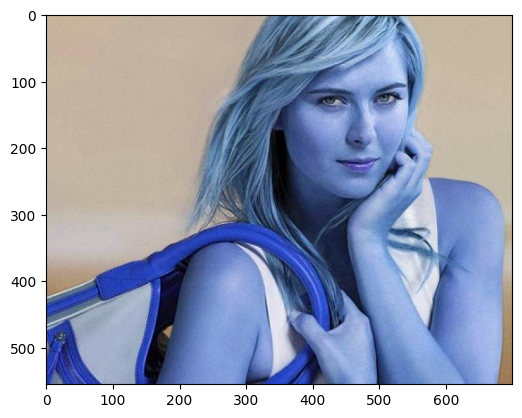

In [165]:
img = cv2.imread('./test_image/sharapova1.jpg')
plt.imshow(img)

In [91]:
def get_cropped_image_if_2_eyes(image_path):
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) 
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)
    for (x,y,w,h) in faces:
        roi_gray = gray[y:y+h, x:x+w]
        roi_color = img[y:y+h, x:x+w]
        eyes = eye_cascade.detectMultiScale(roi_gray)
        if len(eyes) >=2:
            return roi_color

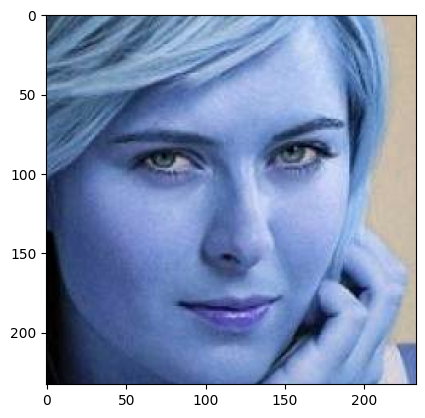

In [176]:
cropped_img = get_cropped_image_if_2_eyes('./test_image/sharapova1.jpg')
plt.imshow(cropped_image)

In [92]:
path_to_data = "./Dataset/"
path_to_cr_data = "./Dataset/cropped/"

In [93]:
img_dirs =[]
for entry in os.scandir(path_to_data):
    if entry.is_dir():
        img_dirs.append(entry.path)

In [94]:
import shutil
if os.path.exists(path_to_cr_data):
    shutil.rmtree(path_to_cr_data)
os.mkdir(path_to_cr_data)

In [95]:
cropped_image_dirs = []
celebrity_file_names_dict = {}

for img_dir in img_dirs:
    count = 1
    celebrity_name = img_dir.split('/')[-1]
    celebrity_file_names_dict[celebrity_name] = []

    for entry in os.scandir(img_dir):
        roi_color = get_cropped_image_if_2_eyes(entry.path)
        if roi_color is not None:
            cropped_folder = path_to_cr_data + celebrity_name
            if not os.path.exists(cropped_folder):
                os.mkdir(cropped_folder)
                cropped_image_dirs.append(cropped_folder)
                print("Generating cropped images in folder: ", cropped_folder)
                
            cropped_file_name = celebrity_name + str(count) + ".png"
            cropped_file_path = cropped_folder + "/" + cropped_file_name

            cv2.imwrite(cropped_file_path, roi_color)
            celebrity_file_names_dict[celebrity_name].append(cropped_file_path)
            count+=1

Generating cropped images in folder:  ./Dataset/cropped/lionel_messi
Generating cropped images in folder:  ./Dataset/cropped/maria_sharapova
Generating cropped images in folder:  ./Dataset/cropped/roger_federer
Generating cropped images in folder:  ./Dataset/cropped/serena_williams
Generating cropped images in folder:  ./Dataset/cropped/virat_kohli


In [110]:
def w2d(img, mode='haar', level=1):
    imArray = img
    #Datatype conversions
    #convert to grayscale
    imArray = cv2.cvtColor( imArray,cv2.COLOR_RGB2GRAY )
    #convert to float
    imArray =  np.float32(imArray)   
    imArray /= 255;
    # compute coefficients 
    coeffs=pywt.wavedec2(imArray, mode, level=level)

    #Process Coefficients
    coeffs_H=list(coeffs)  
    coeffs_H[0] *= 0;  

    # reconstruction
    imArray_H=pywt.waverec2(coeffs_H, mode);
    imArray_H *= 255;
    imArray_H =  np.uint8(imArray_H)

    return imArray_H

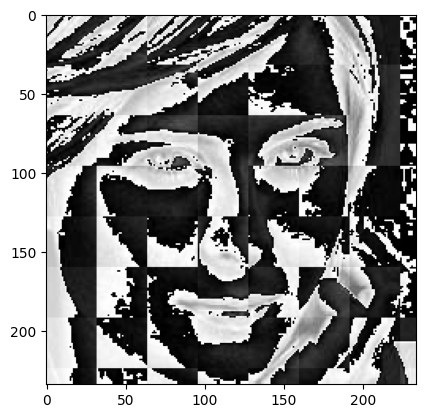

In [178]:
wave_img = w2d(cropped_image, 'db1', 5)
plt.imshow(wave_img, cmap='gray')

In [113]:
celebrity_file_names_dict = {}
for img_dir in cropped_image_dirs:
    celebrity_name = img_dir.split('/')[-1]
    file_list = []
    for entry in os.scandir(img_dir):
        file_list.append(entry.path)
    celebrity_file_names_dict[celebrity_name] = file_list
celebrity_file_names_dict

{'lionel_messi': ['./Dataset/cropped/lionel_messi\\lionel_messi1.png',
  './Dataset/cropped/lionel_messi\\lionel_messi10.png',
  './Dataset/cropped/lionel_messi\\lionel_messi11.png',
  './Dataset/cropped/lionel_messi\\lionel_messi12.png',
  './Dataset/cropped/lionel_messi\\lionel_messi13.png',
  './Dataset/cropped/lionel_messi\\lionel_messi14.png',
  './Dataset/cropped/lionel_messi\\lionel_messi15.png',
  './Dataset/cropped/lionel_messi\\lionel_messi16.png',
  './Dataset/cropped/lionel_messi\\lionel_messi17.png',
  './Dataset/cropped/lionel_messi\\lionel_messi18.png',
  './Dataset/cropped/lionel_messi\\lionel_messi19.png',
  './Dataset/cropped/lionel_messi\\lionel_messi2.png',
  './Dataset/cropped/lionel_messi\\lionel_messi20.png',
  './Dataset/cropped/lionel_messi\\lionel_messi21.png',
  './Dataset/cropped/lionel_messi\\lionel_messi22.png',
  './Dataset/cropped/lionel_messi\\lionel_messi23.png',
  './Dataset/cropped/lionel_messi\\lionel_messi24.png',
  './Dataset/cropped/lionel_messi\

In [114]:
class_dict = {}
count = 0
for celebrity_name in celebrity_file_names_dict.keys():
    class_dict[celebrity_name] = count
    count = count + 1
class_dict

{'lionel_messi': 0,
 'maria_sharapova': 1,
 'roger_federer': 2,
 'serena_williams': 3,
 'virat_kohli': 4}

In [126]:
X, y = [], []
for celebrity_name, training_files in celebrity_file_names_dict.items():
    for training_image in training_files:
        img = cv2.imread(training_image)
        scalled_raw_img = cv2.resize(img, (32, 32))
        img_har = w2d(img,'db1',5)
        scalled_img_har = cv2.resize(img_har, (32, 32))
        combined_img = np.vstack((scalled_raw_img.reshape(32*32*3,1),scalled_img_har.reshape(32*32,1)))
        X.append(combined_img)
        y.append(class_dict[celebrity_name])  

In [127]:
X = np.array(X).reshape(len(X), 4096).astype(float)

In [157]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
import pandas as pd
import seaborn as sn

In [144]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

pipe = Pipeline([('scaler', StandardScaler()), ('svc', SVC(kernel = 'rbf', C = 10))])
pipe.fit(X_train, y_train)
pipe.score(X_test, y_test)

0.7659574468085106

In [137]:
model_params = {
    'svm': {
        'model': svm.SVC(gamma='auto',probability=True),
        'params' : {
            'svc__C': [1,10,100,1000],
            'svc__kernel': ['rbf','linear']
        }  
    },
    'random_forest': {
        'model': RandomForestClassifier(),
        'params' : {
            'randomforestclassifier__n_estimators': [1,5,10]
        }
    },
    'logistic_regression' : {
        'model': LogisticRegression(solver='liblinear',multi_class='auto'),
        'params': {
            'logisticregression__C': [1,5,10]
        }
    }
}

In [141]:
scores = []
best_estimators = {}
for algo, mp in model_params.items():
    pipe = make_pipeline(StandardScaler(), mp['model'])
    clf =  GridSearchCV(pipe, mp['params'], cv=5, return_train_score=False)
    clf.fit(X_train, y_train)
    scores.append({
        'model': algo,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })
    best_estimators[algo] = clf.best_estimator_
    
df = pd.DataFrame(scores,columns=['model','best_score','best_params'])
df

,model,best_score,best_params
0,svm,0.763228,"{'svc__C': 1, 'svc__kernel': 'linear'}"
1,random_forest,0.646825,{'randomforestclassifier__n_estimators': 10}
2,logistic_regression,0.770106,{'logisticregression__C': 1}


In [142]:
best_clf = best_estimators['logistic_regression']

In [145]:
cm = confusion_matrix(y_test, best_clf.predict(X_test))
cm

array([[ 8,  0,  1,  0,  1],
       [ 1,  5,  0,  1,  0],
       [ 1,  0,  5,  0,  0],
       [ 0,  2,  1,  7,  0],
       [ 1,  1,  1,  0, 11]], dtype=int64)

Text(95.72222222222221, 0.5, 'Truth')

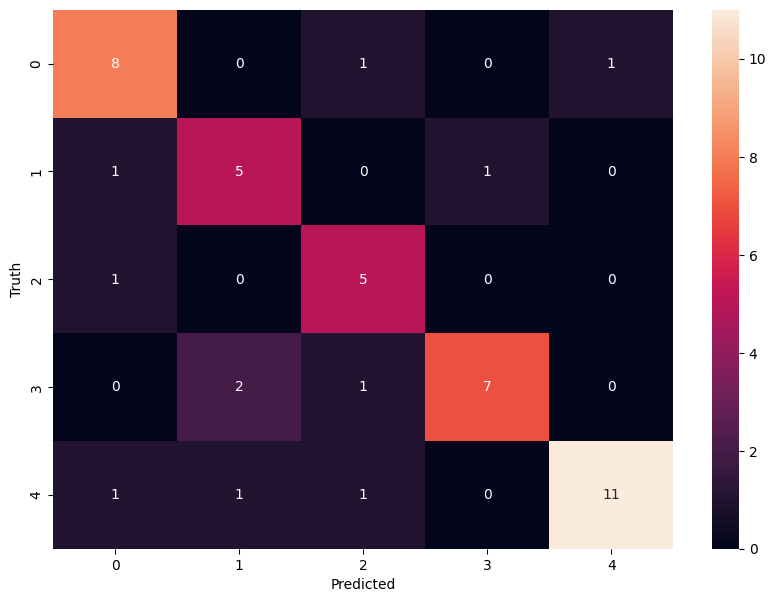

In [147]:
plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [158]:
!pip install joblib
import joblib 
# Save the model as a pickle in a file 
joblib.dump(best_clf, 'saved_model.pkl') 

['saved_model.pkl']

In [159]:
import json
with open("class_dictionary.json","w") as f:
    f.write(json.dumps(class_dict))

TypeError: Image data of dtype object cannot be converted to float

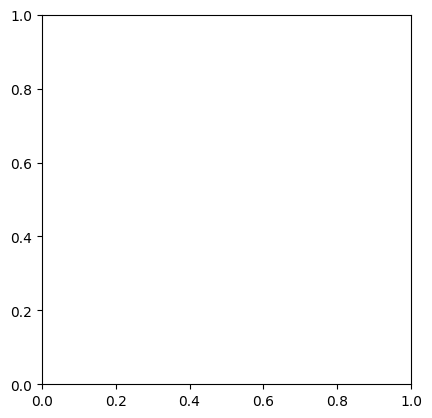

In [161]:
img = cv2.imread('./test_images/sharapova1.jpg')
plt.imshow(img)